Recently, I was working on a project where I had geologic contacts mapped in a vector GIS file and I needed to make rock unit polygons from them. Though the topology was correct in the plugin (i.e. all the lines connected, there were no dangles, etc.) the QGIS plugins failed to create polygons correctly--they would join lines to themselves, and miss other lines, resulting in a number of very small polygons located along curves in contacts. 

I decided that it would be a good exercise to write my own algorithm to do this. After a lot of experimentation, I finally figured out how to go about it.  The basic principle is to start on a contact, and move along it in some direction, and at the end of the contact, consistently take one branch, until you wind up at the original contact.  I chose to do this moving clockwise, and taking the right branch each time.

The algorithm works for me, given properly formatted input contacts. Note that the contacts are split at intersections with other contacts, so if there is a 'T' where one contact meets another in its middle, the top of the 'T' is split into two contacts. This way contacts only meet at endpoints, and each contact only bounds two rock units.

The code to do this is below (with some fake geologic contacts), in case it's useful to others. I have annotated it a little; I hope it's clear.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

## Data preparation


### Step 1
First we load the data, which is a GeoJSON file made up of `LineString`s. We can just load it as a normal JSON file into a Python `dict` object.

In [3]:
import json

with open('../../uploads/demo_graph_data_.geojson') as f:
    contact_gj = json.load(f)
    del f
    
contacts = contact_gj['features']

### Step 2

Now, we will make a list of all of the endpoint vertices, by looping through the contacts.

In [4]:
vertices = []

for feat in contacts:
    start = feat["geometry"]["coordinates"][0]
    stop = feat['geometry']['coordinates'][-1]
    
    if start not in vertices:
        vertices.append(start)
    
    if stop not in vertices:
        vertices.append(stop)

### Step 3

Next, we will add the indices of the enpoint vertices to the contact properties. This just makes the rest of the algorithm a little more clear.

In [5]:
for n, v in enumerate(vertices):
    
    for i, feat in enumerate(contacts):
        if v == feat['geometry']['coordinates'][0]:
            feat['properties']['start'] = n
            
        elif v == feat['geometry']['coordinates'][-1]:
            feat['properties']['stop'] = n

### Step 4

In this step, we will make an adjacency dictionary for the contacts. This is a dictionary with the index for each contact as a key, and lists of the indices of the other contacts that meet at the `start` and `stop` vertices as values.  This dictionary is basically the [graph] of the contacts (in a 'graph theory' sense, not in the sense of a plot) that is abstracted from the geometric details.  This representation is pretty compact (since it doesn't have coordinates) and it is very easy to work with as compared to the full list of contacts.  All of the connectivity properties of the contacts are implicit in the contacts (such as which contacts connect) but those properties are made explicit in the adjacency dictionary.


For clarity in the code below, in graph theory terminology the connection between two vertices or other objects is called an 'edge'. Geologic contacts are edges in this case, and the points they join are the junctions between contacts.

[graph]: https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)


In [6]:
contact_adj_dict = {}

for i, c in enumerate(contacts):
    contact_adj_dict[i] = {'start': [],
                           'stop': []}
    
    for j, cc in enumerate(contacts):
        if j != i:
            if c['properties']['start'] in (
                cc['properties']['start'], cc['properties']['stop']):
                contact_adj_dict[i]['start'].append(j)
            elif c['properties']['stop'] in (
                cc['properties']['start'], cc['properties']['stop']):
                contact_adj_dict[i]['stop'].append(j)

In [7]:
# print the first element for demonstration

contact_adj_dict[0]

{'start': [13], 'stop': [1, 15]}

### Step 5

Now, we need to write some functions to determine which contact of the contacts at a junction branches to the right.

To do this, we will calculate the angle between the final segment of the contact we're on, and the first segment of each of the contacts that meets at this junction.  Then, we choose the right-most angle. (The functions below are just to do the calculations for a single junction; in the next step we will actually perform them on the data.)

In [8]:
def angle_between(c1, c2, c3):
    
    angle = (np.arctan2(c3[1] - c1[1], c3[0] - c1[0]) -
             np.arctan2(c2[1] - c1[1], c2[0] - c1[0]))
    
    if angle < 0:
        angle +=  2 * np.pi
    
    return angle
    
    
def get_angles(edge_0, adj_edges):
    
    vertex = contacts[edge_0]['geometry']['coordinates'][-1]
    next_back = contacts[edge_0]['geometry']['coordinates'][-2]
    
    adj_angles = {}
    
    for edge in adj_edges:
        if contacts[edge]['geometry']['coordinates'][0] == vertex:
            next_up = contacts[edge]['geometry']['coordinates'][1]
        elif contacts[edge]['geometry']['coordinates'][-1] == vertex:
            next_up = contacts[edge]['geometry']['coordinates'][-2]
        
        adj_angles[edge] = angle_between(vertex, next_back, next_up)
        
    return adj_angles
    
    
def get_right_branch(edge_0, side='stop', verbose=False):
    """
    This function starts at a contact (called `edge_0`) and calculates
    the angles between the adjacent contacts at a side (either `stop` or
    `start`) and then chooses the right-branching contact, and the opposite
    side for the next contact.
    
    For example, if we are at `edge_0` and `edge_2` is the right-branching contact,
    and the `start` side of `edge_2` meets `edge_0`, then the next side will be `stop`.
    
    """
    
    
    if side == 'stop':
        vert_ind = -1
        next_ind = -2
    elif side == 'start':
        vert_ind = 0
        next_ind = 1
        
    vertex = contacts[edge_0]['geometry']['coordinates'][vert_ind]
    next_back = contacts[edge_0]['geometry']['coordinates'][next_ind]
    
    adj_edges = contact_adj_dict[edge_0][side]
   
    adj_angles = {}
    adj_sides = {}
    
    for edge in adj_edges:
        if contacts[edge]['geometry']['coordinates'][0] == vertex:
            next_up = contacts[edge]['geometry']['coordinates'][1]
            _next_side = 'stop'
        elif contacts[edge]['geometry']['coordinates'][-1] == vertex:
            next_up = contacts[edge]['geometry']['coordinates'][-2]
            _next_side = 'start'
        
        adj_angles[edge] = angle_between(vertex, next_back, next_up)
        adj_sides[edge] = _next_side
        
    if verbose is True:
        print(adj_angles)
    
    right_edge = min(adj_angles, key=adj_angles.get)
    next_side = adj_sides[right_edge]
    
    return right_edge, next_side

### Step 6

Now, we need a function that will move from contact to contact, delineating the 'cycle' of contacts that surround a polygon. This is most easily done with a [recursive] function, i.e. one that calls itself in the function body. This function needs three arguments: The edge to analyse, the side of the edge to look for the next edge (i.e. which endpoint), and a list of the edges/contacts that it has been to. These lists are important in recursive functions because without them, it's not easy to determine when to stop.

Essentially, the `walk_cycle` function below starts on a contact, adds it to a list, then moves to the next right-branching contact and adds it to the list, until it reaches a contact that is already in the list. If we consistently, correctly choose the right branch, we the first time we revisit a contact, it will be the contact we started on originally.


[recursive]: https://en.wikipedia.org/wiki/Recursion_(computer_science)

In [9]:
def walk_cycle(edge_0, side='stop', visited=None, verbose=False):
    
    if visited is None:
        visited = [edge_0]
        next_branch, next_side = get_right_branch(edge_0, side,
                                                  verbose=verbose)
        visited = walk_cycle(next_branch, next_side, 
                             visited=visited, verbose=verbose)
        return visited
        
    elif edge_0 in visited:
        visited.append(edge_0)
        return visited
    
    else:
        visited.append(edge_0)
        next_branch, next_side = get_right_branch(edge_0, side,
                                                  verbose=verbose)
        visited = walk_cycle(next_branch, next_side, 
                             visited=visited, verbose=verbose)
        return visited


### Step 7

Now, we can actually go through with the computations.

We will start with an empty list called `cycle_list`.  Then we'll start the `walk_cycle` function from each contact. It should return a list of all the contacts in each clockwise cycle. Then, we'll make a [`set`] from the list of contacts in each cycle. In Python, a `set` is an unordered list of objects with the constraint that each object can only be listed once. This lets us check if a polygon is already represented (with a different starting contact) since each polygon will have a unique set of contacts.

In [10]:
cycle_list = []

for i, contact in enumerate(contacts):
    cyc = walk_cycle(i, 'stop')
    
    if set(cyc) not in [set(c) for c in cycle_list]:
        cycle_list.append(cyc)

Now, let's check out the first contact cycle/polygon. Note that this is an ordered list of the contacts, it doesn't have spatial coordinates yet.

In [11]:
cycle_list[0]

[0, 15, 31, 36, 8, 13, 0]

## Plotting

It's important to check the results by looking at the final product.  Below are some functions to extract the geographic coordinates in order for each contact cycle, and then plot them.

In [12]:
def ordered_coords_from_cycles(cycle):
    
    contact_list = deepcopy(cycle)
    
    for i in range(len(contact_list)-2):
        c0 = contact_list[i]
        c1 = contact_list[i+1]
        
        cs0 = deepcopy(contacts[c0]['geometry']['coordinates'])
        cs1 = deepcopy(contacts[c1]['geometry']['coordinates'])
        
        cs0 = [tuple(c) for c in cs0]
        cs1 = [tuple(c) for c in cs1]
        
        start_0 = cs0[0]
        start_1 = cs1[0]
        stop_0 =  cs0[-1]
        stop_1 =  cs1[-1]
       
        if i == 0:
            if (stop_0 == start_1) or (stop_0 == stop_1):
                coord_list = cs0
            elif (start_0 == start_1) or (start_0 == stop_1):
                coord_list = cs0[::-1]
            else:
                raise Exception('0,1 contacts not matching')
                
        if start_1 == coord_list[-1]:
            coord_list += cs1[1:]
        elif stop_1 == coord_list[-1]:
            coord_list += cs1[::-1][1:]
            
    return coord_list


def plot_cycle_coords(cycle):
    
    coord_list = ordered_coords_from_cycles(cycle)
    
    plt.plot(*x_y_from_coord_list(coord_list))
    

def x_y_from_coord_list(clist):
    xs = [c[0] for c in clist]
    ys = [c[1] for c in clist]
    
    return xs, ys

Let's now look at the first cycle's coordinates:

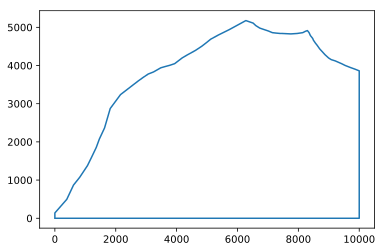

In [13]:
plot_cycle_coords(cycle_list[0])

Finally, let's plot all of the cycles/polygons to see what it looks like:

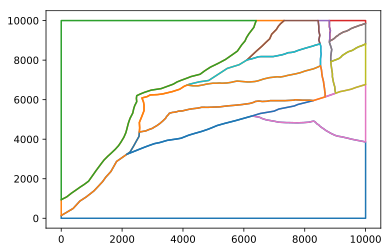

In [12]:
plt.figure()

for cyc in cycle_list:
    plot_cycle_coords(cyc)

This is correct. Because there is a bit of overplotting of some contacts going on, each polygon doesn't show the outline in a single color. But the ones plotted later on do.

## Export

Finally, we have a list of coordinates that delineate each polygon. Here we make new GeoJSON Polygon features for each polygon and write a new file with those features.

We'll first copy the original GeoJSON dictionary (which has the coordinate system information and structure) and then rewrite the `feature` list.

In [14]:
polys = deepcopy(contact_gj)

polys['features'] = []

for i, cyc in enumerate(cycle_list):
    
    coord_list = [list(c) for c in ordered_coords_from_cycles(cyc)]
    
    poly = {'properties': {'fid': i+1,
                           'unit_name': '',
                           'rock_type': '',
                          },
            'geometry': {'coordinates': [coord_list],
                         'type': 'Polygon'},
            'type': 'Feature'
           }
    polys['features'].append(poly)

Then, we'll write it to a new geojson file.

In [15]:
with open('../../uploads/demo_graph_polys.geojson', 'w') as f:
    json.dump(polys, f)